# A computational introduction to stochastic differential equations.

Lecture 7.

https://github.com/spdes/computational-sde-intro-lecture.

$$
d
\begin{bmatrix}
    X_1(t) \\ X_2(t) \\ X_3(t)
\end{bmatrix}
=
\begin{bmatrix}
    0 & 1 & 0 \\
    -\Bigl(\frac{\sqrt{3}}{g(X_3(t))}\Bigr)^2 & \frac{-2 \, \sqrt{3}}{g(X_3(t))} & 0 \\
    0 & 0 & -1
\end{bmatrix}
\begin{bmatrix}
    X_1(t) \\ X_2(t) \\ X_3(t)
\end{bmatrix}
dt +
\begin{bmatrix}
    0 & 0 \\
    2 \, \Bigl(\frac{\sqrt{3}}{g(X_3(t))}\Bigr)^{\frac{3}{2}} \, \sigma & 0 \\
    0 & 1
\end{bmatrix}
d W(t) \\
Y_k = \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} X(t_k) + \xi_k
$$

Choose $g(x) = \exp(x)$

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy
import matplotlib.pyplot as plt
import math
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
# Dimensions of the state and measurement variables
sigma = 1.

# SDE coefficients
def g(x): return jnp.exp(x)

def drift(x):
    l = math.sqrt(3) / g(x[-1])
    return jnp.array([[0., 1., 0.],
                      [-l ** 2, -2 * l, 0.],
                      [0., 0., -1.]]) @ x

def dispersion(x):
    l = math.sqrt(3) / g(x[-1])
    return jnp.diag(jnp.array([0., 2 * l ** 1.5 * sigma, 1.]))

# Discretise the SDE at the times by Euler--Maruyama
def m_and_cov(x, dt):
    b = dispersion(x)
    return x + drift(x) * dt, b @ b.T * dt

# Measurement noise covariance
H = jnp.array([1., 0., 0.])
Xi = 1.

# Initial mean and covariance
m0 = jnp.zeros((3, ))
V0 = jnp.eye(3)

In [3]:
# Times
T = 2000
dt = 0.01
ts = jnp.linspace(dt, dt * T, T)

# Random key
key = jax.random.PRNGKey(999)

Now we generate a pair of trajectory and its measurements at the times.

In [4]:
# Generate initial value
x0 = m0 + jnp.linalg.cholesky(V0) @ jax.random.normal(key, (3, ))
key, _ = jax.random.split(key)

rnds = jax.random.normal(key, (T, 4))
key, _ = jax.random.split(key)

def scan_body(carry, elem):
    x = carry
    rnd_x, rnd_y = elem

    m, cov = m_and_cov(x, dt)
    x = m + jnp.sqrt(cov) @ rnd_x
    y = jnp.dot(H, x) + math.sqrt(Xi) * rnd_y
    return x, (x, y)

_, (xs, ys) = jax.lax.scan(scan_body, x0, (rnds[:, :3], rnds[:, -1]))

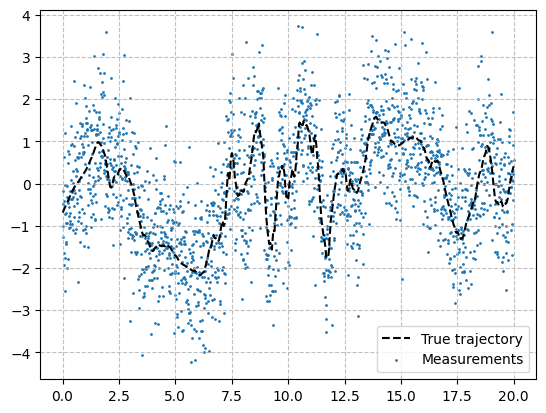

In [5]:
plt.plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
plt.scatter(ts, ys, s=1, label='Measurements')
plt.legend()
plt.grid(linestyle='--', alpha=0.8, which='both')

In [6]:
def ekf(ys):
    def scan_body(carry, elem):
        mf, Vf, n_ell = carry
        y = elem

        jac_F = jax.jacfwd(lambda u: m_and_cov(u, dt)[0], argnums=0)(mf)
        mp, Sigma = m_and_cov(mf, dt)
        Vp = jac_F @ Vf @ jac_F.T + Sigma

        S = jnp.dot(H, Vp @ H) + Xi
        K = Vp @ H / S
        mf = mp + K * (y - H @ mp)
        Vf = Vp - jnp.outer(K, K) * S
        n_ell -= jax.scipy.stats.norm.logpdf(y, H @ mp, jnp.sqrt(S))
        return (mf, Vf, n_ell), (mf, Vf, n_ell)

    _, (mfs, Pfs, n_ell) = jax.lax.scan(scan_body, (m0, V0, 0.), ys)
    return mfs, Pfs, n_ell

def eks(mfs, Vfs):
    def scan_body(carry, elem):
        ms, Vs = carry
        mf, Vf = elem

        jac_F = jax.jacfwd(lambda u: m_and_cov(u, dt)[0], argnums=0)(mf)
        mp, Sigma = m_and_cov(mf, dt)
        Vp = jac_F @ Vf @ jac_F.T + Sigma

        DT = jac_F @ Vf
        c, low = jax.scipy.linalg.cho_factor(Vp)
        G = jax.scipy.linalg.cho_solve((c, low), DT).T
        ms = mf + G @ (ms - mp)
        Vs = Vf + G @ (Vs - Vp) @ G.T
        return (ms, Vs), (ms, Vs)

    _, (mss, Vss) = jax.lax.scan(scan_body, (mfs[-1], Vfs[-1]), (mfs[:-1], Vfs[:-1]), reverse=True)
    return jnp.vstack([mss, mfs[-1]]), jnp.vstack([Vss, Vfs[-1, None]])

We then run the filter and smoother.

In [7]:
mfs, Vfs, n_ell = ekf(ys)
mss, Vss = eks(mfs, Vfs)

Plot

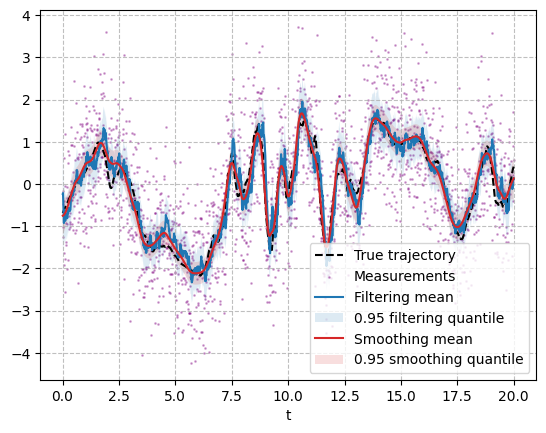

In [11]:
plt.plot(ts, xs[:, 0], c='black', linestyle='--', label='True trajectory')
plt.scatter(ts, ys, s=1, c='purple', alpha=0.3, label='Measurements')
plt.plot(ts, mfs[:, 0], c='tab:blue', label='Filtering mean')
plt.fill_between(ts,
                 mfs[:, 0] - 1.96 * jnp.sqrt(Vfs[:, 0, 0]),
                 mfs[:, 0] + 1.96 * jnp.sqrt(Vfs[:, 0, 0]),
                 color='tab:blue',
                 edgecolor='none',
                 alpha=0.15,
                 label='0.95 filtering quantile')

plt.plot(ts, mss[:, 0], c='tab:red', label='Smoothing mean')
plt.fill_between(ts,
                 mss[:, 0] - 1.96 * jnp.sqrt(Vss[:, 0, 0]),
                 mss[:, 0] + 1.96 * jnp.sqrt(Vss[:, 0, 0]),
                 color='tab:red',
                 edgecolor='none',
                 alpha=0.15,
                 label='0.95 smoothing quantile')

plt.legend()
plt.xlabel('t')
plt.grid(linestyle='--', alpha=0.8, which='both')

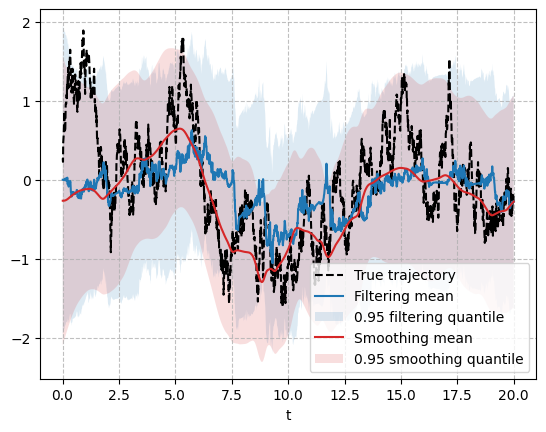

In [9]:
plt.plot(ts, xs[:, 2], c='black', linestyle='--', label='True trajectory')
plt.plot(ts, mfs[:, 2], c='tab:blue', label='Filtering mean')
plt.fill_between(ts,
                 mfs[:, 2] - 1.96 * jnp.sqrt(Vfs[:, 2, 2]),
                 mfs[:, 2] + 1.96 * jnp.sqrt(Vfs[:, 2, 2]),
                 color='tab:blue',
                 edgecolor='none',
                 alpha=0.15,
                 label='0.95 filtering quantile')

plt.plot(ts, mss[:, 2], c='tab:red', label='Smoothing mean')
plt.fill_between(ts,
                 mss[:, 2] - 1.96 * jnp.sqrt(Vss[:, 2, 2]),
                 mss[:, 2] + 1.96 * jnp.sqrt(Vss[:, 2, 2]),
                 color='tab:red',
                 edgecolor='none',
                 alpha=0.15,
                 label='0.95 smoothing quantile')

plt.legend()
plt.xlabel('t')
plt.grid(linestyle='--', alpha=0.8, which='both')